In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Robust path finding for data.mat
current_path = Path.cwd()
possible_data_paths = [
    current_path / 'data' / 'data.mat',
    current_path.parent / 'data' / 'data.mat',
    current_path.parent.parent / 'data' / 'data.mat',
    # Fallback absolute path
    Path('/home/luky/skola/KalmanNet-for-state-estimation/data/data.mat')
]

dataset_path = None
for p in possible_data_paths:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None or not dataset_path.exists():
    print("Warning: data.mat not found automatically.")
    dataset_path = Path('data/data.mat')

print(f"Dataset path: {dataset_path}")

# Add project root to sys.path (2 levels up from debug/test)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


Dataset path: /home/luky/skola/KalmanNet-main/data/data.mat
Project root added: /home/luky/skola/KalmanNet-main
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
# initial_velocity_np = torch.from_numpy()
initial_velocity = torch.from_numpy(np.array([0,0]))

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([1487547.1250, 6395520.5000,       0.0000,       0.0000])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import TAN
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
from utils import trainer # Předpokládám, že toto máš

# === 1. ZJEDNODUŠENÝ DATA MANAGER (BEZ NORMALIZACE) ===
class NavigationDataManager:
    def __init__(self, data_dir):
        """
        Jen držák na cestu k datům. Žádná statistika, žádná normalizace.
        """
        self.data_dir = data_dir
        
    def get_dataloader(self, seq_len, split='train', shuffle=True, batch_size=32):
        # Sestavení cesty: ./generated_data/len_100/train.pt
        path = os.path.join(self.data_dir, f'len_{seq_len}', f'{split}.pt')
        
        if not os.path.exists(path):
            raise FileNotFoundError(f"❌ Dataset nenalezen: {path}")
            
        # Načtení tenzorů
        data = torch.load(path)
        x = data['x'] # Stav [Batch, Seq, DimX]
        y = data['y'] # Měření [Batch, Seq, DimY] - RAW DATA
        
        # Vytvoření datasetu
        dataset = TensorDataset(x, y)
        
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# === 2. KONFIGURACE CURRICULA ===
DATA_DIR = './generated_data_clean_motion'

# Inicializace manažera (teď je to jen wrapper pro načítání souborů)
data_manager = NavigationDataManager(DATA_DIR)

# Definice fází (zde řídíš, jak se trénink vyvíjí)
curriculum_schedule = [
    # FÁZE 1: Warm-up (Krátké sekvence)
    {
        'phase_id': 1,
        'seq_len': 10,          
        'epochs': 500,           
        'lr': 1e-3, 
        'batch_size': 256
    },
    
    # FÁZE 2: Stabilizace (Střední délka)
    {
        'phase_id': 2,
        'seq_len': 100, 
        'epochs': 200, 
        'lr': 1e-4,             
        'batch_size': 128
    },
    
    # FÁZE 3: Long-term Reality (Plná délka)
    {
        'phase_id': 3,
        'seq_len': 300,         
        'epochs': 200, 
        'lr': 1e-5,             
        'batch_size': 64       # Menší batch kvůli paměti GPU u dlouhých sekvencí
    }
]

# === 3. NAČÍTÁNÍ DO PAMĚTI (CACHING) ===
print("\n=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===")
datasets_cache = {} 

for phase in curriculum_schedule:
    seq_len = phase['seq_len']
    bs = phase['batch_size']
    
    print(f"📥 Načítám Fázi {phase['phase_id']}: Seq={seq_len} | Batch={bs} ...")
    
    try:
        # Použití DataManageru
        train_loader = data_manager.get_dataloader(seq_len=seq_len, split='train', shuffle=True, batch_size=bs)
        val_loader = data_manager.get_dataloader(seq_len=seq_len, split='val', shuffle=False, batch_size=bs)
        
        # Uložení do cache
        datasets_cache[phase['phase_id']] = (train_loader, val_loader)
        
        # Rychlá kontrola pro jistotu
        x_ex, y_ex = next(iter(train_loader))
        if phase['phase_id'] == 1:
            print(f"   🔎 Ukázka RAW dat (y): {y_ex[0, 0, :].tolist()}") 
            # Měl bys vidět velká čísla (např. 250.0) a malá (0.2), ne ~0.0
        
    except FileNotFoundError as e:
        print(f"   ⚠️ CHYBA: {e}")
        # raise e # Odkomentuj, pokud chceš, aby to spadlo při chybě

print("\n✅ Data připravena. Normalizaci řeší model.")


=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===
📥 Načítám Fázi 1: Seq=10 | Batch=256 ...
   🔎 Ukázka RAW dat (y): [362.96917724609375, -12.126676559448242, 0.16327548027038574]
📥 Načítám Fázi 2: Seq=100 | Batch=128 ...
📥 Načítám Fázi 3: Seq=300 | Batch=64 ...

✅ Data připravena. Normalizaci řeší model.


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy
import torch

def calculate_anees_vectorized(x_true: torch.Tensor, x_hat: torch.Tensor, P_hat: torch.Tensor) -> float:
    """
    Vektorizovaný výpočet ANEES (Average Normalized Estimation Error Squared)
    pro plné kovarianční matice.
    
    Parametry:
    x_true: Tensor tvaru (Batch, SeqLen, StateDim) - skutečné stavy (Ground Truth)
    x_hat: Tensor tvaru (Batch, SeqLen, StateDim) - odhadnuté stavy filtrem
    P_hat: Tensor tvaru (Batch, SeqLen, StateDim, StateDim) - odhadnuté plné kovarianční matice
    
    Návratová hodnota:
    Skalár - průměrná hodnota ANEES (ideálně by se měla blížit StateDim, pro TAN to je 4.0)
    """
    # 1. Výpočet chyby odhadu (epsilon)
    error = x_true - x_hat  # Tvar: (B, Seq, Dim)
    
    # 2. Sloučení Batch a SeqLen dimenzí pro hromadný vektorizovaný výpočet
    B, Seq, Dim = error.shape
    
    # Přetvarujeme na sloupcové vektory pro lineární algebru: (B*Seq, Dim, 1)
    error_flat = error.reshape(B * Seq, Dim, 1)
    
    # Přetvarujeme kovariance: (B*Seq, Dim, Dim)
    P_hat_flat = P_hat.reshape(B * Seq, Dim, Dim)
    
    # 3. Zajištění numerické stability (prevence singulárních matic)
    # Tzv. "Jitter" nebo Tichonovova regularizace - přidáme velmi malé číslo na diagonálu
    eye = torch.eye(Dim, device=P_hat.device, dtype=P_hat.dtype).unsqueeze(0).expand(B * Seq, -1, -1)
    P_hat_stable = P_hat_flat + 1e-6 * eye
    
    # 4. Výpočet P^{-1} * error
    # Matematicky nejstabilnější cesta je vyřešit soustavu rovnic P * y = error  =>  y = P^{-1} * error
    try:
        # y má tvar (B*Seq, Dim, 1)
        y = torch.linalg.solve(P_hat_stable, error_flat)
    except RuntimeError as e:
        print(f"⚠️ Varování při výpočtu ANEES (Singulární matice zjištěna). Fallback na pseudoinverzi: {e}")
        # Bezpečnostní pojistka: pokud by matice i přes regularizaci zkolabovala, použijeme SVD pseudoinverzi
        P_inv = torch.linalg.pinv(P_hat_stable)
        y = torch.bmm(P_inv, error_flat)
        
    # 5. Výpočet kvadratické formy: error^T * y  (což je error^T * P^{-1} * error)
    # Transpozice error_flat: (B*Seq, 1, Dim)
    error_flat_T = error_flat.transpose(1, 2)
    
    # Výsledek maticového násobení (bmm) bude mít tvar (B*Seq, 1, 1)
    nees = torch.bmm(error_flat_T, y)
    
    # Odstraníme zbytečné dimenze -> (B*Seq,)
    nees = nees.squeeze()
    
    # 6. ANEES je zprůměrovaná hodnota NEES přes všechny batche a všechny časové kroky
    anees_value = nees.mean().item()
    
    return anees_value
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def train_BayesianKalmanNet_Hybrid(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad,
    J_samples, validation_period, logging_period, # logging_period zde nechávám pro kompatibilitu
    warmup_iterations=0, 
    weight_decay_=1e-5,
    lambda_mse=100.0,
    calibration_parameter=0.0,
    force_seq_len=None,
    add_noise=False
):
    # ---------------------------------------------------------
    # ROZDĚLENÍ PARAMETRŮ PRO OPTIMALIZÁTOR (PER-PARAMETER LR)
    # ---------------------------------------------------------
    p_logits_params = []
    base_params = []
    
    for name, param in model.named_parameters():
        if 'p_logit' in name:
            p_logits_params.append(param)
        else:
            base_params.append(param)

    # p_logits dostanou silný fixní learning rate (např. 1e-2) a žádný weight decay.
    # Zbytek sítě (base_params) používá LR z Curricula.
    optimizer = torch.optim.AdamW([
        {'params': base_params, 'lr': learning_rate, 'weight_decay': weight_decay_},
        {'params': p_logits_params, 'lr': 1e-4, 'weight_decay': 0.0} 
    ])
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.5, patience=50, verbose=False # Vypnuto spamování od scheduleru
    # )

    best_hybrid_score = float('inf')
    best_iter_count = 0
    best_model_state = None
    
    best_val_mse = float('inf')
    best_val_anees = float('inf')

    train_iter_count = 0
    done = False

    # --- AGREGÁTORY TRÉNOVACÍCH METRIK ---
    running_loss = 0.0
    running_mse = 0.0
    running_nll = 0.0
    steps_since_val = 0

    print(f"🚀 START Hybrid Training | Cíl: {total_train_iter} iterací")
    if force_seq_len:
        print(f"    ✂️  Ořez dat: Max délka sekvence = {force_seq_len}")
    if add_noise:
        print(f"    🌪️  Data Augmentation: ZAPNUTO (Šum v počátečním stavu)")
    print("-" * 100)

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            
            # --- OŘEZÁNÍ DAT (SLICING) ---
            if force_seq_len is not None and x_true_batch.shape[1] > force_seq_len:
                x_true_batch = x_true_batch[:, :force_seq_len, :]
                y_meas_batch = y_meas_batch[:, :force_seq_len, :]
            
            if torch.isnan(x_true_batch).any(): continue
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            batch_size, seq_len, state_dim = x_true_batch.shape
            
            optimizer.zero_grad()
            
            # ==========================================
            # 1. VEKTORIZOVANÉ MC VZORKOVÁNÍ
            # ==========================================
            mc_batch_size = batch_size * J_samples
            x_true_mc = x_true_batch.repeat(J_samples, 1, 1)
            y_meas_mc = y_meas_batch.repeat(J_samples, 1, 1)
            
            initial_states = x_true_mc[:, 0, :]

            # DATA AUGMENTATION (Pouze při tréninku, ne při validaci/testu)
            if add_noise:
                # 4D stav: přidáme šum s normálním rozdělením 
                # (např. std 10 metrů pro polohu, 0.5 m/s pro rychlost)
                noise_std = torch.tensor([2.0, 2.0, 0.2, 0.2], device=device).unsqueeze(0).expand_as(initial_states)
                start_noise = torch.randn_like(initial_states) * noise_std
                
                noisy_initial_states = initial_states + start_noise
            else:
                noisy_initial_states = initial_states

            model.reset(batch_size=mc_batch_size, initial_state=noisy_initial_states)
            current_trajectory_x_hats = []
            current_trajectory_regs = []
            
            break_flag = False
            for t in range(1, seq_len):
                y_t = y_meas_mc[:, t, :]
                x_filtered_t, reg_t = model.step(y_t)
                
                if torch.isnan(x_filtered_t).any(): 
                    break_flag = True; break
                    
                current_trajectory_x_hats.append(x_filtered_t)
                current_trajectory_regs.append(reg_t)
            
            if break_flag or len(current_trajectory_x_hats) != (seq_len - 1): 
                optimizer.zero_grad(); continue

            # ==========================================
            # 2. ZPRACOVÁNÍ VÝSLEDKŮ
            # ==========================================
            all_x_hats_flat = torch.stack(current_trajectory_x_hats, dim=1)
            all_x_hats = all_x_hats_flat.view(J_samples, batch_size, seq_len - 1, state_dim)
            x_hat_sequence = all_x_hats.mean(dim=0)
            
            x_centered = all_x_hats - x_hat_sequence.unsqueeze(0)
            cov_full_sequence = (1.0 / (J_samples - 1)) * torch.einsum('jbtd,jbtk->btdk', x_centered, x_centered)
            cov_diag_sequence = torch.diagonal(cov_full_sequence, dim1=-2, dim2=-1) + 1e-3
            
            regularization_loss = torch.stack(current_trajectory_regs).mean()
            target_sequence = x_true_batch[:, 1:, :]
            
            # ==========================================
            # 3. VÝPOČET ZTRÁTY (LOSS)
            # ==========================================
            mse_loss = F.mse_loss(x_hat_sequence, target_sequence)
            error_sq = (x_hat_sequence - target_sequence) ** 2
            nll_loss = 0.5 * (torch.log(cov_diag_sequence) + error_sq / cov_diag_sequence).mean()
            
            loss = nll_loss + (lambda_mse * mse_loss) + regularization_loss * 1.0
            
            if torch.isnan(loss): done = True; break
            
            loss.backward()
            if clip_grad > 0: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            
            train_iter_count += 1
            
            # Akumulace pro čistý výpis
            running_loss += loss.item()
            running_mse += mse_loss.item()
            running_nll += nll_loss.item()
            steps_since_val += 1

            # ==========================================
            # 4. VALIDACE A ČISTÝ VÝPIS LOGŮ
            # ==========================================
            if train_iter_count > 0 and train_iter_count % validation_period == 0:
                # Zprůměrování trénovacích metrik od poslední validace
                avg_t_loss = running_loss / steps_since_val
                avg_t_mse = running_mse / steps_since_val
                avg_t_nll = running_nll / steps_since_val
                
                # Reset akumulátorů
                running_loss, running_mse, running_nll, steps_since_val = 0.0, 0.0, 0.0, 0
                
                # scheduler.step(avg_t_loss)
                model.eval()
                val_mse_list = []
                val_pos_std_list = [] # Pro sběr průměrné neurčitosti v poloze
                all_val_x_true, all_val_x_hat, all_val_P_hat = [], [], []

                with torch.no_grad():
                    # --- EXTRAKCE DROPOUT PRAVDĚPODOBNOSTÍ ---
                    # Sigmoid převede logity na reálnou pravděpodobnost 0-1
                    p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                    p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()

                    for x_true_val, y_meas_val in val_loader:
                        if force_seq_len is not None and x_true_val.shape[1] > force_seq_len:
                            x_true_val = x_true_val[:, :force_seq_len, :]
                            y_meas_val = y_meas_val[:, :force_seq_len, :]

                        v_bs, v_seq, _ = x_true_val.shape
                        x_true_val = x_true_val.to(device)
                        y_meas_val = y_meas_val.to(device)
                        
                        v_mc_bs = v_bs * J_samples
                        v_x_true_mc = x_true_val.repeat(J_samples, 1, 1)
                        v_y_meas_mc = y_meas_val.repeat(J_samples, 1, 1)
                        
                        model.reset(batch_size=v_mc_bs, initial_state=v_x_true_mc[:, 0, :])
                        
                        v_x_hats_list = []
                        for t in range(1, v_seq):
                            est, _ = model.step(v_y_meas_mc[:, t, :])
                            v_x_hats_list.append(est)
                            
                        v_all_x_hats_flat = torch.stack(v_x_hats_list, dim=1)
                        v_all_x_hats = v_all_x_hats_flat.view(J_samples, v_bs, v_seq - 1, state_dim)
                        
                        val_mean = v_all_x_hats.mean(dim=0)
                        v_x_centered = v_all_x_hats - val_mean.unsqueeze(0)
                        val_covs_full = (1.0 / (J_samples - 1)) * torch.einsum('jbtd,jbtk->btdk', v_x_centered, v_x_centered)
                        
                        eye_matrix = torch.eye(state_dim, device=device).view(1, 1, state_dim, state_dim)
                        val_covs_full = val_covs_full + eye_matrix * 1e-6
                        
                        val_mse_list.append(F.mse_loss(val_mean, x_true_val[:, 1:, :]).item())
                        
                        # --- VÝPOČET PRŮMĚRNÉ NEURČITOSTI V POLOZE ---
                        # Předpokládáme, že index 0 je px a index 1 je py.
                        # Směrodatná odchylka je odmocnina z rozptylu (diagonály).
                        std_px = torch.sqrt(val_covs_full[:, :, 0, 0])
                        std_py = torch.sqrt(val_covs_full[:, :, 1, 1])
                        # Průměrná směrodatná odchylka polohy pro tento batch
                        batch_pos_std = ((std_px + std_py) / 2.0).mean().item()
                        val_pos_std_list.append(batch_pos_std)

                        full_x_hat = torch.cat([x_true_val[:, 0, :].unsqueeze(1), val_mean], dim=1)
                        P0 = model.system_model.P0.unsqueeze(0).repeat(v_bs, 1, 1).unsqueeze(1)
                        full_P_hat = torch.cat([P0, val_covs_full], dim=1)
                        
                        all_val_x_true.append(x_true_val.cpu())
                        all_val_x_hat.append(full_x_hat.cpu())
                        all_val_P_hat.append(full_P_hat.cpu())

                avg_val_mse = np.mean(val_mse_list)
                avg_val_pos_std = np.mean(val_pos_std_list) # Toto je naše nové diagnostické číslo
                
                try:
                    avg_val_anees = calculate_anees_vectorized(
                        torch.cat(all_val_x_true, dim=0),
                        torch.cat(all_val_x_hat, dim=0),
                        torch.cat(all_val_P_hat, dim=0)
                    )
                except Exception:
                    avg_val_anees = 100.0

                anees_diff = abs(avg_val_anees - state_dim)
                hybrid_score = avg_val_mse + (calibration_parameter * anees_diff)

                # Vyhodnocení, zda máme nový nejlepší model
                best_marker = ""
                if hybrid_score < best_hybrid_score:
                    best_hybrid_score = hybrid_score
                    best_iter_count = train_iter_count
                    best_val_mse = avg_val_mse
                    best_val_anees = avg_val_anees
                    best_model_state = deepcopy(model.state_dict())
                    best_marker = " ⭐ NEW BEST!"

                # === NOVÝ ROZŠÍŘENÝ FORMÁT LOGU ===
                mode = "Warmup" if train_iter_count < warmup_iterations else "Hybrid"
                print(f"[{train_iter_count:4d}/{total_train_iter}] {mode} | "
                      f"Tr (Loss: {avg_t_loss:.2f}, MSE: {avg_t_mse:.1f}, NLL: {avg_t_nll:.2f}) | "
                      f"Val (MSE: {avg_val_mse:.1f}, ANEES: {avg_val_anees:.1f}) | "
                      f"Diag (σ_pos: \033[93m±{avg_val_pos_std:.1f}m\033[0m, p1: {p1:.2f}, p2: {p2:.2f}){best_marker}")
                
                model.train()

    print("-" * 100)
    print(f"✅ Trénink dokončen. Načítám nejlepší model z iterace {best_iter_count} "
          f"(Val MSE: {best_val_mse:.4f}, Val ANEES: {best_val_anees:.4f})")
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return {"final_model": model, "best_val_mse": best_val_mse, "best_val_anees": best_val_anees}

In [8]:
import torch
import copy
import os
# from state_NN_models import TAN # Import modelu

# --- 1. MAPOVÁNÍ DOSTUPNÝCH DAT (CACHE) ---
# Předpokládám toto rozložení v datasets_cache. 
# Pokud to máte jinak (např. 300 je na indexu 0), upravte čísla vpravo.
seq_len_to_idx = {
    10: 1,    # Data délky 10
    100: 2,   # Data délky 100
    300: 3    # Data délky 300
}
import gc # Pro úklid paměti

# ... (tvůj předchozí kód zůstává stejný)

curriculum_schedule = [
    {
        'phase_id': 1,
        'target_seq_len': 10,
        'source_data_len': 10,   
        'iters': 600,
        'lr': 1e-3,
        'lambda_mse': 1.0, 
        'clip_grad': 1.0,
        'mse_warmup_iters': 600, 
        'calibration_parameter': 0.0,
        'j_samples': 10  # <--- Přidáno
    },
    # {
    #     'phase_id': 2, 
    #     'target_seq_len': 25,    
    #     'source_data_len': 100,  
    #     'iters': 800,
    #     'lr': 1e-4,              
    #     'clip_grad': 0.5,        
    #     'lambda_mse': 0.0,       
    #     'mse_warmup_iters': 300, 
    #     'calibration_parameter': 0.0,
    #     'j_samples': 10  # <--- Přidáno
    # },
    {
        'phase_id': 3,
        'target_seq_len': 50,    
        'source_data_len': 300,  
        'iters': 1000,
        'lr': 5e-5,              
        'clip_grad': 0.5,
        'lambda_mse': 1.0,       
        'mse_warmup_iters': 300, 
        'calibration_parameter': 1.0,
        'j_samples': 10   # <--- Lehce sníženo pro jistotu
    },
{
        'phase_id': 4,
        'target_seq_len': 100,   
        'source_data_len': 100,
        'iters': 2000,           # Dáme mu trochu víc času na 100 kroků
        'lr': 1e-5,              # <--- OPRAVA 2: Malinko vyšší LR než 1e-5 pro překonání šoku
        'clip_grad': 0.5,        # <--- OPRAVA 3: Vracíme na 0.5 (0.24 bylo moc přísné)
        'lambda_mse': 2.0,       # <--- OPRAVA 4: Necháme to na 1.0! Nechceme síť zabít.
        'mse_warmup_iters': 100, 
        'calibration_parameter': 1.0, # Zůstane 1.0, ANEES při J=5 stejně nemá smysl moc hrotit
        'j_samples': 10   
    }
]

# --- 3. INICIALIZACE MODELU ---
print("=== INICIALIZACE BKN MODELU ===")
state_knet2 = TAN.StateBayesianKalmanNetTAN(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=10,       
        output_layer_multiplier=4,
        num_gru_layers=1,
        init_max_dropout=0.5, 
        init_min_dropout=0.3    
).to(device)

# --- 4. SPUŠTĚNÍ CURRICULA ---
print(f"🚀 START CURRICULUM TRAINING ({len(curriculum_schedule)} fází)")

for phase in curriculum_schedule:
    # --- DŮLEŽITÉ: VYČIŠTĚNÍ PAMĚTI PŘED KAŽDOU FÁZÍ ---
    torch.cuda.empty_cache()
    gc.collect()

    pid = phase['phase_id']
    target_len = phase['target_seq_len']
    source_len = phase['source_data_len']
    current_j_samples = phase.get('j_samples', 5) # Načtení z konfigurace
    
    print(f"\n" + "="*60)
    print(f"🌊 FÁZE {pid}: Cílová délka {target_len} (Zdroj dat: {source_len})")
    print(f"   Parametry: LR={phase['lr']}, LambdaMSE={phase['lambda_mse']}, J_samples={current_j_samples}")
    print("="*60)
    
    # 1. Výběr dat podle source_len
    try:
        cache_idx = seq_len_to_idx[source_len]
        train_loader = datasets_cache[cache_idx][0]
        val_loader = datasets_cache[cache_idx][1]
        print(f"   -> Načítám loader z datasets_cache[{cache_idx}] (původní délka dat: {source_len})")
    except KeyError:
        print(f"❌ CHYBA: Nemám definovaný index v 'seq_len_to_idx' pro délku {source_len}!")
        break
    except IndexError:
        print(f"❌ CHYBA: Index {cache_idx} neexistuje v datasets_cache!")
        break

    phase_results = train_BayesianKalmanNet_Hybrid(
    model=state_knet2,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    
    total_train_iter=phase['iters'],
    learning_rate=phase['lr'],
    warmup_iterations=phase['mse_warmup_iters'],
    clip_grad=phase['clip_grad'],
    lambda_mse=phase['lambda_mse'],
    calibration_parameter=phase.get('calibration_parameter', 0.0),
    force_seq_len=target_len, 
    
    J_samples=current_j_samples,  # <--- POUŽITÍ DYNAMICKÉHO J_samples
    validation_period=10,
    logging_period=1,
    weight_decay_=1e-2,
    add_noise=True
    )
    
    if not os.path.exists("checkpoints"): os.makedirs("checkpoints")
    torch.save(state_knet2.state_dict(), f"checkpoints/bkn_phase_{pid}_len{target_len}.pth")
    print(f"✅ Fáze {pid} dokončena. Model uložen.")

print("\n🏆 CELÝ TRÉNINK DOKONČEN.")

=== INICIALIZACE BKN MODELU ===
INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně 

KeyboardInterrupt: 

In [ ]:
if False:
    # save model.
    save_path = f'best_mse_and_anees_bknet.pth'
    torch.save(state_knet2.state_dict(), save_path)
    print(f"Model saved to '{save_path}'.")

In [ ]:
# import torch
# from state_NN_models import TAN # Tvůj import

# # 1. Cesta k uloženému modelu z konce Fáze 4 (zkontroluj si přesný název v tvé složce)
# checkpoint_path = "checkpoints/bkn_phase_4_len100.pth"

# # 2. Inicializace prázdného modelu (musí mít naprosto shodné parametry jako v tréninku!)
# best_bkn_model = TAN.StateBayesianKalmanNetTAN(
#     system_model=system_model, 
#     device=device,
#     hidden_size_multiplier=8,       
#     output_layer_multiplier=4,
#     num_gru_layers=1,
#     init_max_dropout=0.5, 
#     init_min_dropout=0.3    
# ).to(device)

# # 3. Nahrání natrénovaných vah do modelu
# # (map_location zajistí, že se to správně nahraje na CPU nebo GPU podle toho, co zrovna používáš)
# best_bkn_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# state_knet2=best_bkn_model
# # 4. Přepnutí modelu do evaluačního (testovacího) režimu
# best_bkn_model.eval()

# print("✅ Nejlepší BKN model úspěšně načten a je připraven k testování!")

# Test na synteticke trajektorii

=== SPUŠTĚNÍ MONTE CARLO SIMULACE (2 běhů) ===
Modely: BKN (J=100) vs. UKF vs. PF


Processing sequence PF: 100%|██████████| 1275/1275 [00:07<00:00, 178.93it/s]


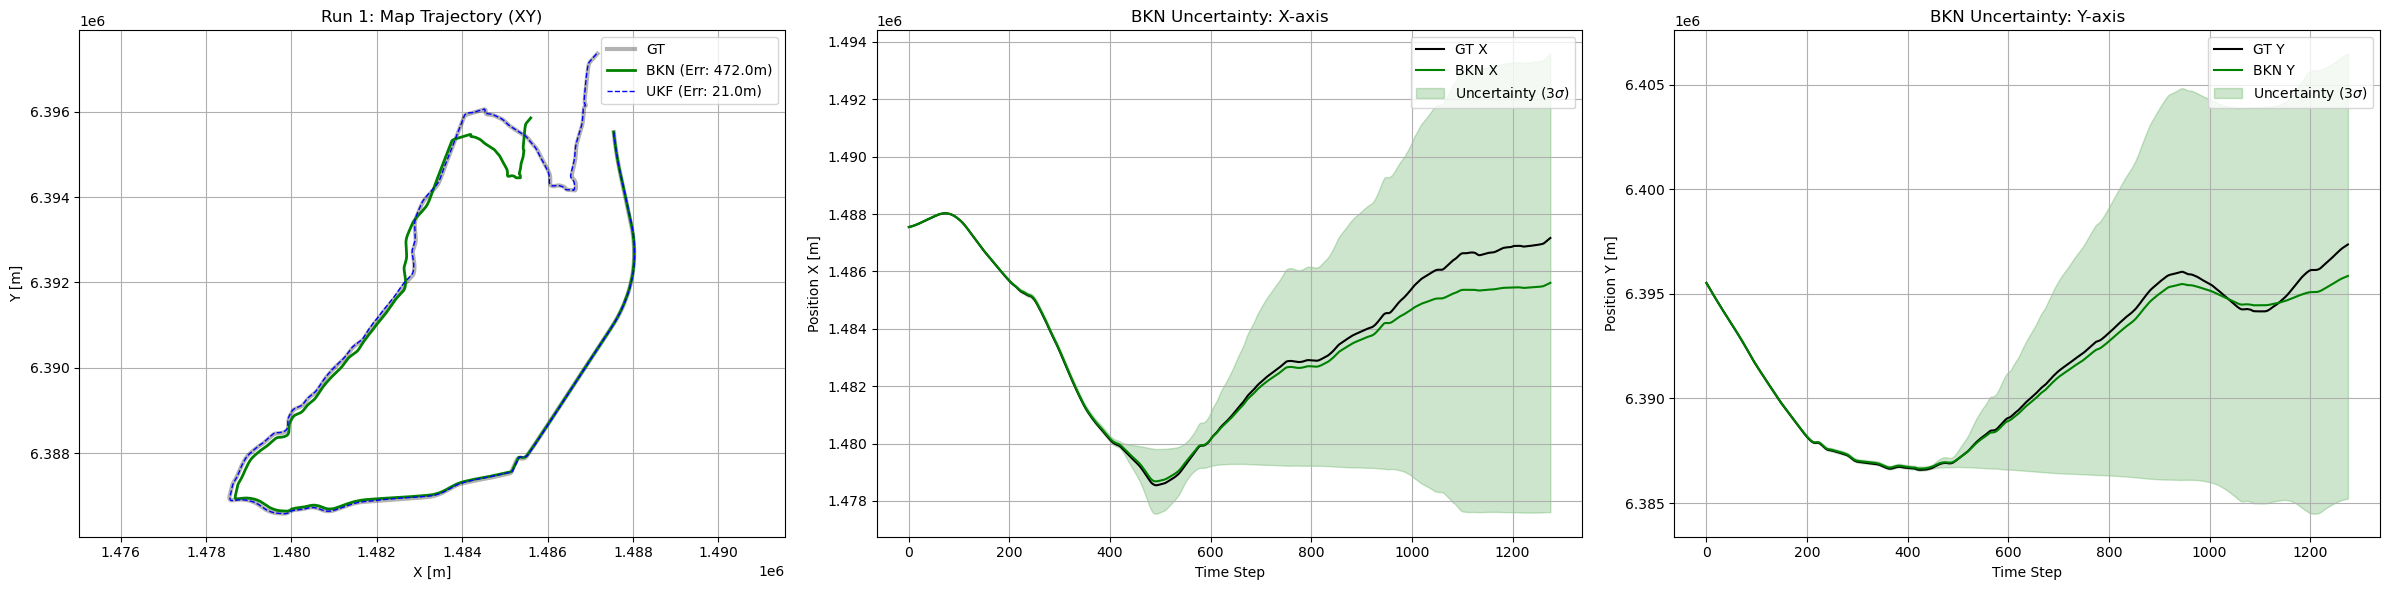

Processing sequence PF: 100%|██████████| 1275/1275 [00:07<00:00, 170.22it/s]


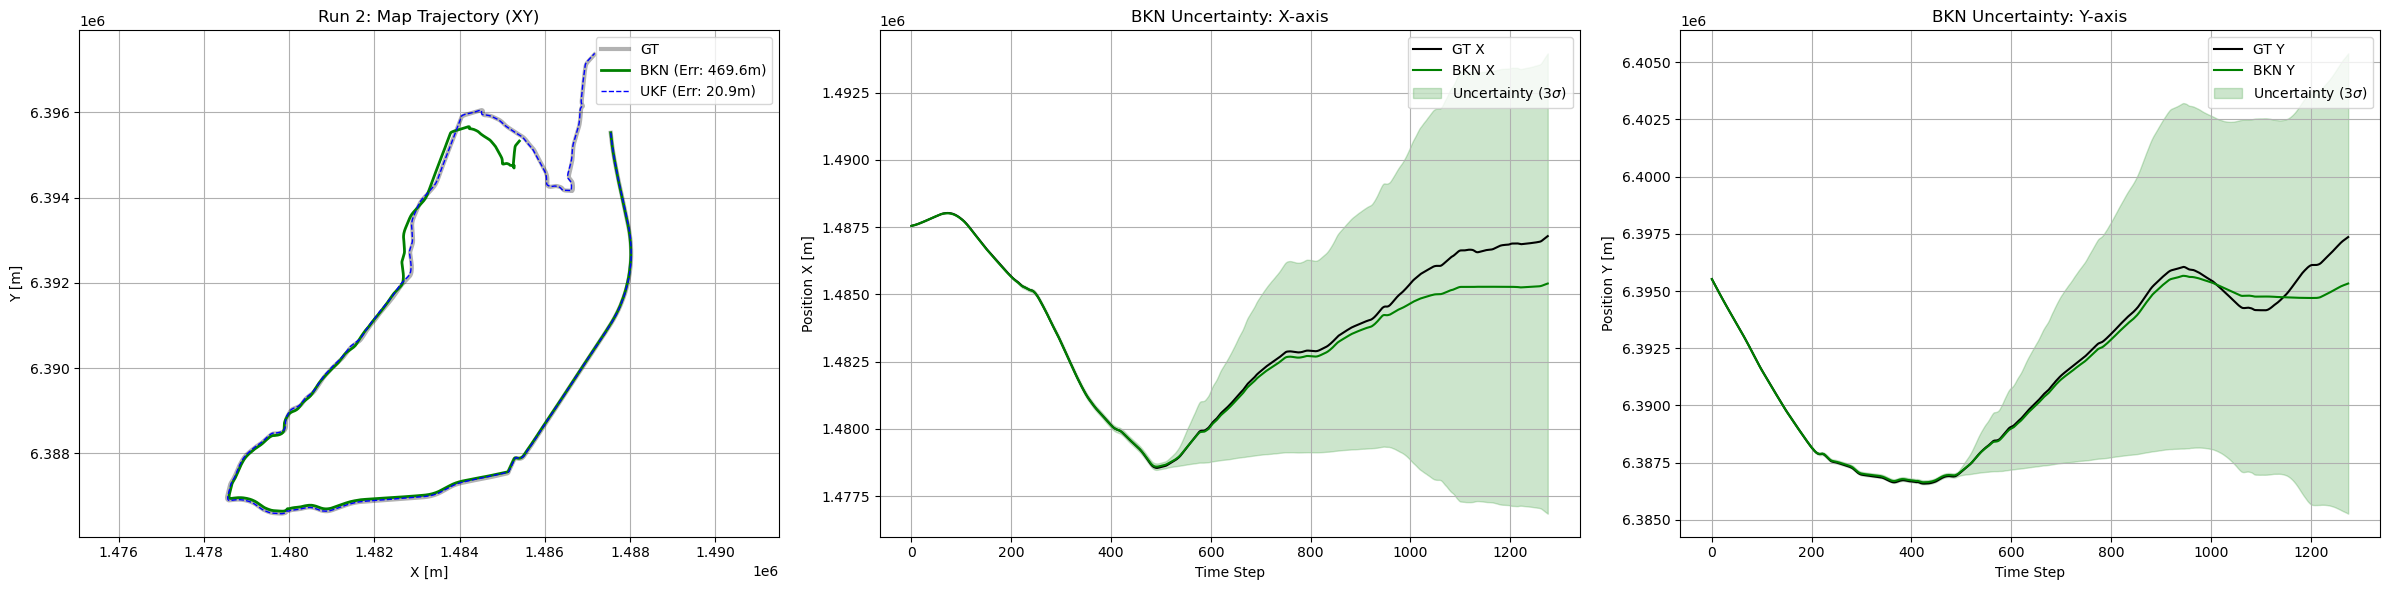

Simulace: 100%|██████████| 2/2 [06:34<00:00, 197.40s/it]


SOUHRNNÁ STATISTIKA (2 běhů)
Model           | MSE                       | Pos Error                
---------------------------------------------------------------------------
BKN (Ensemble)  | 150524.9 ± 16701.1 | 470.81 ± 1.16 m
UKF             | 140.2 ± 7.5 | 20.93 ± 0.03 m
PF              | 15030.8 ± 12365.4 | 112.36 ± 20.17 m


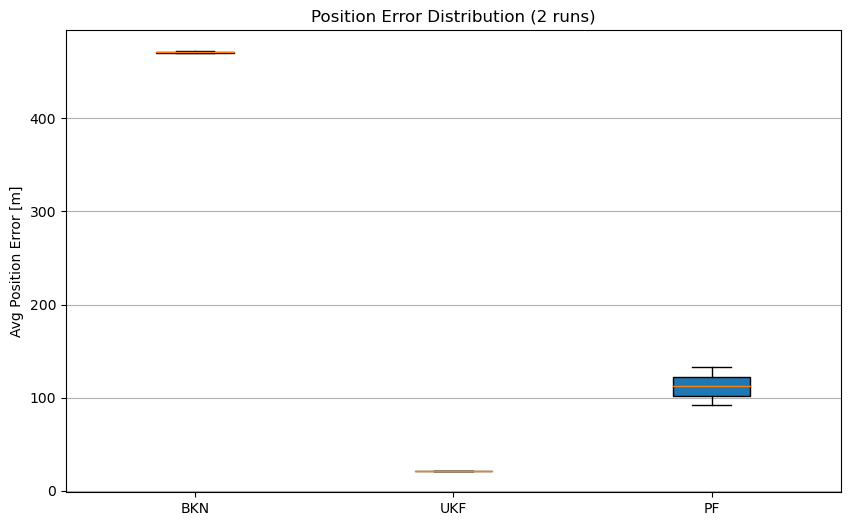

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import Filters
import torch.nn.functional as F
from tqdm import tqdm

# === KONFIGURACE MC ===
MC_ITERATIONS = 2  
J_SAMPLES = 100      
PLOT_PER_ITERATION = True  # True = vykreslí grafy (první a poslední běh), False = žádné grafy

# Příprava dat
real_traj_np = souradniceGNSS[:2, :].T 
real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)

# --- POMOCNÁ FUNKCE ---
def get_reference_test_set(system, real_traj_tensor):
    device = system.Ex0.device
    hB_np = mat_data['hB']
    real_hB_tensor = torch.from_numpy(hB_np).float().to(device).view(-1)

    pos_full = real_traj_tensor.clone().to(device)
    deltas = pos_full[1:] - pos_full[:-1] 
    last_vel = deltas[-1:]
    velocities = torch.cat([deltas, last_vel], dim=0) 
    
    x_traj_flat = torch.cat([pos_full, velocities], dim=1) 
    y_traj_flat = system.measure(x_traj_flat) 
    
    seq_len = x_traj_flat.shape[0]
    y_traj_flat[:, 0] = real_hB_tensor[:seq_len] 
    
    x_ref = x_traj_flat.unsqueeze(0) 
    y_ref = y_traj_flat.unsqueeze(0) 
    
    return x_ref, y_ref

print(f"=== SPUŠTĚNÍ MONTE CARLO SIMULACE ({MC_ITERATIONS} běhů) ===")
print(f"Modely: BKN (J={J_SAMPLES}) vs. UKF vs. PF")

# 1. Příprava Ground Truth
x_ref_tensor_static, _ = get_reference_test_set(system_model, real_traj_tensor)
x_gt = x_ref_tensor_static.squeeze().cpu().numpy()
seq_len = x_gt.shape[0]

# 2. Inicializace metrik
detailed_results = []
agg_metrics = {
    "BKN": {"mse": [], "pos": []}, 
    "UKF": {"mse": [], "pos": []}, 
    "PF":  {"mse": [], "pos": []}
}

state_knet2.train() 

# --- HLAVNÍ SMYČKA ---
for i in tqdm(range(MC_ITERATIONS), desc="Simulace"):
    
    # A) Nové měření (náhodný šum)
    _, y_ref_tensor = get_reference_test_set(system_model, real_traj_tensor)
    y_meas = y_ref_tensor 
    
    # B) Inference: BKN Ensemble
    with torch.no_grad():
        initial_state = x_ref_tensor_static[:, 0, :] 
        ensemble_preds = []
        
        for j in range(J_SAMPLES):
            state_knet2.reset(batch_size=1, initial_state=initial_state)
            trajectory_preds = []
            for t in range(1, seq_len):
                y_t = y_meas[:, t, :]
                x_est, _ = state_knet2.step(y_t)
                trajectory_preds.append(x_est)
            
            trajectory_tensor = torch.stack(trajectory_preds, dim=1) 
            full_traj = torch.cat([initial_state.unsqueeze(1), trajectory_tensor], dim=1)
            ensemble_preds.append(full_traj)
            
        ensemble_stack = torch.stack(ensemble_preds, dim=0) 
        x_est_bkn_tensor = ensemble_stack.mean(dim=0).squeeze(0) 
        cov_diag_bkn = ensemble_stack.var(dim=0).squeeze(0) + 1e-9 
        
        x_est_bkn = x_est_bkn_tensor.cpu().numpy()
        std_bkn = torch.sqrt(cov_diag_bkn).cpu().numpy() 

    # C) Inference: UKF & PF
    y_for_filters = y_ref_tensor.squeeze(0) 
    true_init_state = x_ref_tensor_static[0, 0, :] 
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(y_seq=y_for_filters, Ex0=true_init_state, P0=system_model.P0)
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

    # PF
    pf = Filters.ParticleFilter(system_model, num_particles=5000) 
    pf_res = pf.process_sequence(y_seq=y_for_filters, Ex0=true_init_state, P0=system_model.P0)
    x_est_pf = pf_res['x_filtered'].cpu().numpy()

    # D) Výpočet chyb
    def calc_errors(x_est, x_gt):
        diff = x_est - x_gt
        mse = np.mean(diff**2)
        pos_err = np.mean(np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
        return mse, pos_err

    mse_bkn, pos_bkn = calc_errors(x_est_bkn, x_gt)
    mse_ukf, pos_ukf = calc_errors(x_est_ukf, x_gt)
    mse_pf, pos_pf = calc_errors(x_est_pf, x_gt)
    
    agg_metrics["BKN"]["mse"].append(mse_bkn); agg_metrics["BKN"]["pos"].append(pos_bkn)
    agg_metrics["UKF"]["mse"].append(mse_ukf); agg_metrics["UKF"]["pos"].append(pos_ukf)
    agg_metrics["PF"]["mse"].append(mse_pf);   agg_metrics["PF"]["pos"].append(pos_pf)

    detailed_results.append({
        "Run_ID": i + 1,
        "BKN_MSE": mse_bkn, "UKF_MSE": mse_ukf, "PF_MSE": mse_pf,
        "BKN_Pos": pos_bkn, "UKF_Pos": pos_ukf, "PF_Pos": pos_pf
    })
    
    # E) VYKRESLENÍ (Upraveno pro X i Y s neurčitostí)
    # Vykreslíme jen první a poslední běh, abychom nezahltili výstup, pokud je PLOT_PER_ITERATION True
    if PLOT_PER_ITERATION and (i == 0 or i == MC_ITERATIONS-1):
        fig, ax = plt.subplots(1, 3, figsize=(24, 6)) # 3 grafy vedle sebe
        
        # 1. Graf: Trajektorie v mapě (XY)
        ax[0].plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='GT')
        ax[0].plot(x_est_bkn[:, 0], x_est_bkn[:, 1], 'g-', linewidth=2, label=f'BKN (Err: {pos_bkn:.1f}m)')
        ax[0].plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (Err: {pos_ukf:.1f}m)')
        ax[0].set_title(f"Run {i+1}: Map Trajectory (XY)")
        ax[0].set_xlabel("X [m]")
        ax[0].set_ylabel("Y [m]")
        ax[0].legend()
        ax[0].grid(True)
        ax[0].axis('equal')
        
        # Společná časová osa
        time_steps = np.arange(seq_len)

        # 2. Graf: Vývoj X v čase s neurčitostí
        ax[1].plot(time_steps, x_gt[:, 0], 'k-', label='GT X')
        ax[1].plot(time_steps, x_est_bkn[:, 0], 'g-', label='BKN X')
        # Pásmo neurčitosti X (+/- 3 sigma)
        ax[1].fill_between(time_steps, 
                           x_est_bkn[:, 0] - 3*std_bkn[:, 0], 
                           x_est_bkn[:, 0] + 3*std_bkn[:, 0], 
                           color='green', alpha=0.2, label='Uncertainty (3$\sigma$)')
        ax[1].set_title("BKN Uncertainty: X-axis")
        ax[1].set_ylabel("Position X [m]")
        ax[1].set_xlabel("Time Step")
        ax[1].legend()
        ax[1].grid(True)

        # 3. Graf: Vývoj Y v čase s neurčitostí
        ax[2].plot(time_steps, x_gt[:, 1], 'k-', label='GT Y')
        ax[2].plot(time_steps, x_est_bkn[:, 1], 'g-', label='BKN Y')
        # Pásmo neurčitosti Y (+/- 3 sigma)
        ax[2].fill_between(time_steps, 
                           x_est_bkn[:, 1] - 3*std_bkn[:, 1], 
                           x_est_bkn[:, 1] + 3*std_bkn[:, 1], 
                           color='green', alpha=0.2, label='Uncertainty (3$\sigma$)')
        ax[2].set_title("BKN Uncertainty: Y-axis")
        ax[2].set_ylabel("Position Y [m]")
        ax[2].set_xlabel("Time Step")
        ax[2].legend()
        ax[2].grid(True)

        plt.tight_layout()
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*80)
print(f"SOUHRNNÁ STATISTIKA ({MC_ITERATIONS} běhů)")
print("="*80)

def get_stats_str(key):
    m_mse, s_mse = np.mean(agg_metrics[key]["mse"]), np.std(agg_metrics[key]["mse"])
    m_pos, s_pos = np.mean(agg_metrics[key]["pos"]), np.std(agg_metrics[key]["pos"])
    return f"{m_mse:.1f} ± {s_mse:.1f} | {m_pos:.2f} ± {s_pos:.2f} m"

print(f"{'Model':<15} | {'MSE':<25} | {'Pos Error':<25}")
print("-" * 75)
print(f"{'BKN (Ensemble)':<15} | {get_stats_str('BKN')}")
print(f"{'UKF':<15} | {get_stats_str('UKF')}")
print(f"{'PF':<15} | {get_stats_str('PF')}")
print("="*80)

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([agg_metrics["BKN"]["pos"], agg_metrics["UKF"]["pos"], agg_metrics["PF"]["pos"]], 
            labels=['BKN', 'UKF', 'PF'], patch_artist=True)
plt.title(f"Position Error Distribution ({MC_ITERATIONS} runs)")
plt.ylabel("Avg Position Error [m]")
plt.grid(True, axis='y')
plt.show()